In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

from tqdm import tqdm
import random




# Goal

The June edition of the 2022 Tabular Playground series is all about data imputation. The dataset has similarities to the May 2022 Tabular Playground, except that there are no targets. Rather, there are missing data values in the dataset, and your task is to predict what these values should be.

For this challenge, you are given (simulated) manufacturing control data that contains missing values due to electronic errors. Your task is to predict the values of all missing data in this dataset. (Note, while there are continuous and categorical features, only the continuous features have missing values.)

In [2]:
data = pd.read_csv('../input/tabular-playground-series-jun-2022/data.csv')
sub = pd.read_csv('../input/tabular-playground-series-jun-2022/sample_submission.csv')

print(data.shape)
print(sub.shape)

(1000000, 81)
(1000000, 2)


In [3]:
data.head(3)

,row_id,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,F_1_10,F_1_11,F_1_12,F_1_13,F_1_14,F_2_0,F_2_1,F_2_2,F_2_3,F_2_4,F_2_5,F_2_6,F_2_7,F_2_8,F_2_9,F_2_10,F_2_11,F_2_12,F_2_13,F_2_14,F_2_15,F_2_16,F_2_17,F_2_18,F_2_19,F_2_20,F_2_21,F_2_22,F_2_23,F_2_24,F_3_0,F_3_1,F_3_2,F_3_3,F_3_4,F_3_5,F_3_6,F_3_7,F_3_8,F_3_9,F_3_10,F_3_11,F_3_12,F_3_13,F_3_14,F_3_15,F_3_16,F_3_17,F_3_18,F_3_19,F_3_20,F_3_21,F_3_22,F_3_23,F_3_24,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,-1.416075,1.201521,0.551902,-0.759827,NaN,2,2,0,3,2,1,1,3,2,2,3,3,2,5,4,1,0,1,0,2,1,2,0,1,2,-0.240522,0.061529,0.561090,-0.171943,-0.431996,0.473508,0.596924,0.819306,1.479061,1.264616,-1.116881,0.759443,-0.086915,-0.620685,0.057216,1.076380,-0.780608,-1.940907,-0.717021,0.599093,0.498347,0.118770,-0.228913,NaN,0.301610,5.547214,1.066871,-0.134313,-0.101040,-0.660871,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,-0.853630,0.674525,0.843058,-0.041438,0.259496,3,5,2,1,4,2,3,2,0,0,9,3,1,4,1,2,1,0,1,1,1,1,3,2,5,-0.446068,1.433358,0.040099,-1.994062,-0.602324,-0.611391,-1.151884,0.065485,0.352023,-0.843751,1.167272,0.921445,-0.839827,0.759015,-1.547387,0.720435,-0.944045,1.796462,-1.046357,-0.581515,0.704543,0.375222,0.705963,0.032771,NaN,-1.707374,-1.188114,-0.562419,-1.462988,1.290672,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,2,0.256023,-1.059874,NaN,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,-0.073235,-1.381605,-0.108676,0.703693,-0.464042,3,2,1,3,2,1,0,6,1,1,3,4,1,2,2,1,2,2,4,8,1,5,1,2,4,-0.770592,0.483139,-0.636484,-1.305018,-2.089889,0.276761,-1.208640,-0.855769,0.232363,0.215841,-1.031405,0.582437,-0.314639,-0.497409,0.489356,0.915049,-0.513410,0.904206,-0.056089,0.212927,-0.574126,-1.517749,-0.888472,0.142264,1.000822,1.914908,3.877128,NaN,0.358635,0.443973,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576


In [4]:
def eda(df):
    summary = pd.DataFrame()
    summary['dtype'] = df.dtypes
    summary['miss'] = df.isnull().sum()
    summary['nlevel'] = df.nunique()
    summary['misspct'] = summary.miss/len(df)
    
    return summary

summary = eda(data)
summary
    

,dtype,miss,nlevel,misspct
row_id,int64,0,1000000,0.000000
F_1_0,float64,18397,859226,0.018397
F_1_1,float64,18216,858873,0.018216
F_1_2,float64,18008,859449,0.018008
F_1_3,float64,18250,858808,0.018250
...,...,...,...,...
F_4_10,float64,18225,808561,0.018225
F_4_11,float64,18119,954202,0.018119
F_4_12,float64,18306,927039,0.018306
F_4_13,float64,17995,927488,0.017995


In [5]:
summary.sort_values(by = 'miss')

,dtype,miss,nlevel,misspct
row_id,int64,0,1000000,0.000000
F_2_7,int64,0,17,0.000000
F_2_8,int64,0,14,0.000000
F_2_9,int64,0,12,0.000000
F_2_10,int64,0,18,0.000000
...,...,...,...,...
F_3_11,float64,18388,858867,0.018388
F_3_21,float64,18396,807857,0.018396
F_1_0,float64,18397,859226,0.018397
F_1_13,float64,18398,817211,0.018398


In [6]:
summary.sort_values(by = 'dtype').head(30)

,dtype,miss,nlevel,misspct
row_id,int64,0,1000000,0.000000
F_2_7,int64,0,17,0.000000
F_2_8,int64,0,14,0.000000
F_2_9,int64,0,12,0.000000
F_2_10,int64,0,18,0.000000
F_2_11,int64,0,14,0.000000
F_2_12,int64,0,16,0.000000
F_2_13,int64,0,16,0.000000
F_2_14,int64,0,14,0.000000
F_2_15,int64,0,14,0.000000


In [7]:
num_cols = data.select_dtypes(include = 'float64').columns
num_cols

Index(['F_1_0', 'F_1_1', 'F_1_2', 'F_1_3', 'F_1_4', 'F_1_5', 'F_1_6', 'F_1_7',
       'F_1_8', 'F_1_9', 'F_1_10', 'F_1_11', 'F_1_12', 'F_1_13', 'F_1_14',
       'F_3_0', 'F_3_1', 'F_3_2', 'F_3_3', 'F_3_4', 'F_3_5', 'F_3_6', 'F_3_7',
       'F_3_8', 'F_3_9', 'F_3_10', 'F_3_11', 'F_3_12', 'F_3_13', 'F_3_14',
       'F_3_15', 'F_3_16', 'F_3_17', 'F_3_18', 'F_3_19', 'F_3_20', 'F_3_21',
       'F_3_22', 'F_3_23', 'F_3_24', 'F_4_0', 'F_4_1', 'F_4_2', 'F_4_3',
       'F_4_4', 'F_4_5', 'F_4_6', 'F_4_7', 'F_4_8', 'F_4_9', 'F_4_10',
       'F_4_11', 'F_4_12', 'F_4_13', 'F_4_14'],
      dtype='object')

In [8]:
cat_cols = data.select_dtypes(include = 'int64').columns
cat_cols

Index(['row_id', 'F_2_0', 'F_2_1', 'F_2_2', 'F_2_3', 'F_2_4', 'F_2_5', 'F_2_6',
       'F_2_7', 'F_2_8', 'F_2_9', 'F_2_10', 'F_2_11', 'F_2_12', 'F_2_13',
       'F_2_14', 'F_2_15', 'F_2_16', 'F_2_17', 'F_2_18', 'F_2_19', 'F_2_20',
       'F_2_21', 'F_2_22', 'F_2_23', 'F_2_24'],
      dtype='object')

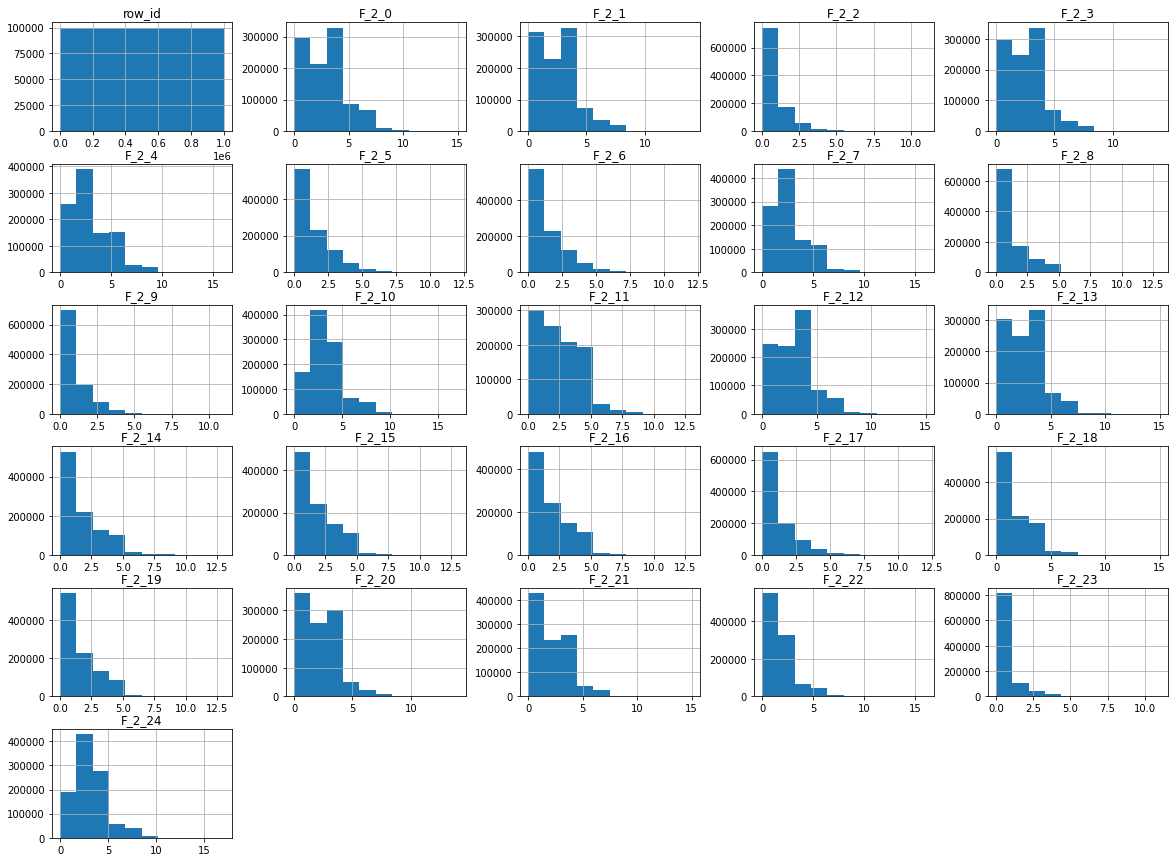

In [9]:
data[cat_cols].hist(figsize = (20,15))
plt.show()

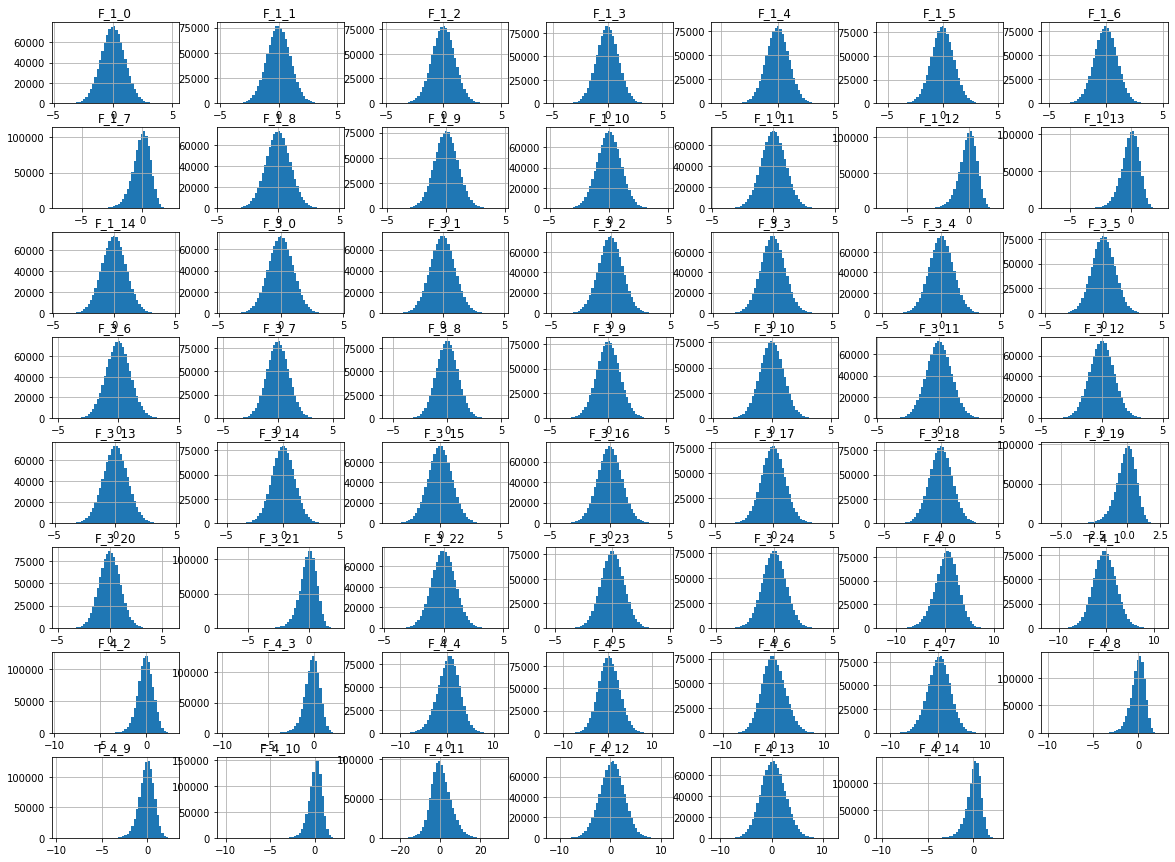

In [10]:
data[num_cols].hist(figsize = (20,15), bins = 50)
plt.show()

# Mean Imputation

In [11]:
for c in num_cols:
    data[c] = data[c].fillna(data[c].median())
    

In [12]:
data.head()

,row_id,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,F_1_9,F_1_10,F_1_11,F_1_12,F_1_13,F_1_14,F_2_0,F_2_1,F_2_2,F_2_3,F_2_4,F_2_5,F_2_6,F_2_7,F_2_8,F_2_9,F_2_10,F_2_11,F_2_12,F_2_13,F_2_14,F_2_15,F_2_16,F_2_17,F_2_18,F_2_19,F_2_20,F_2_21,F_2_22,F_2_23,F_2_24,F_3_0,F_3_1,F_3_2,F_3_3,F_3_4,F_3_5,F_3_6,F_3_7,F_3_8,F_3_9,F_3_10,F_3_11,F_3_12,F_3_13,F_3_14,F_3_15,F_3_16,F_3_17,F_3_18,F_3_19,F_3_20,F_3_21,F_3_22,F_3_23,F_3_24,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,0,-0.354591,-0.464038,2.304115,0.734486,1.696395,0.136285,-0.518344,0.502640,-1.852504,-0.500665,-1.416075,1.201521,0.551902,-0.759827,-0.000161,2,2,0,3,2,1,1,3,2,2,3,3,2,5,4,1,0,1,0,2,1,2,0,1,2,-0.240522,0.061529,0.561090,-0.171943,-0.431996,0.473508,0.596924,0.819306,1.479061,1.264616,-1.116881,0.759443,-0.086915,-0.620685,0.057216,1.076380,-0.780608,-1.940907,-0.717021,0.599093,0.498347,0.118770,-0.228913,-0.000452,0.301610,5.547214,1.066871,-0.134313,-0.101040,-0.660871,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,1,1.380940,-0.499626,-0.418548,1.911725,-0.826130,-1.715371,-0.577091,-1.041486,0.596067,-0.363425,-0.853630,0.674525,0.843058,-0.041438,0.259496,3,5,2,1,4,2,3,2,0,0,9,3,1,4,1,2,1,0,1,1,1,1,3,2,5,-0.446068,1.433358,0.040099,-1.994062,-0.602324,-0.611391,-1.151884,0.065485,0.352023,-0.843751,1.167272,0.921445,-0.839827,0.759015,-1.547387,0.720435,-0.944045,1.796462,-1.046357,-0.581515,0.704543,0.375222,0.705963,0.032771,-0.000457,-1.707374,-1.188114,-0.562419,-1.462988,1.290672,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,2,0.256023,-1.059874,0.001386,0.345678,1.513814,1.243864,-0.509648,-0.800481,-0.115945,0.595777,-0.073235,-1.381605,-0.108676,0.703693,-0.464042,3,2,1,3,2,1,0,6,1,1,3,4,1,2,2,1,2,2,4,8,1,5,1,2,4,-0.770592,0.483139,-0.636484,-1.305018,-2.089889,0.276761,-1.208640,-0.855769,0.232363,0.215841,-1.031405,0.582437,-0.314639,-0.497409,0.489356,0.915049,-0.513410,0.904206,-0.056089,0.212927,-0.574126,-1.517749,-0.888472,0.142264,1.000822,1.914908,3.877128,-0.061980,0.358635,0.443973,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,3,-0.728420,-2.432399,-2.453602,-0.020509,0.333397,0.086049,-1.787601,0.667011,0.761564,-2.217847,-0.618973,0.742112,0.494157,0.744673,-0.769181,2,3,2,1,1,1,2,0,6,2,6,2,1,1,2,3,1,2,1,2,6,2,1,0,2,-0.691020,-1.003026,0.868989,0.464920,0.002639,0.499838,0.203723,-0.451576,-1.233499,0.903493,1.144558,-1.479893,-0.414316,0.024820,-0.976814,0.176633,-0.940022,-1.918049,1.506448,0.604388,0.578250,-0.122676,-0.711811,0.228523,0.999599,-2.638262,0.546676,0.865400,-0.857077,2.667105,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,4,0.590212,-0.066127,0.468009,-1.096038,0.119399,-1.809710,0.466358,-0.053196,-0.580320,-1.143500,1.338692,1.193330,1.038010,-0.763692,0.513466,5,0,1,3,3,0,2,5,1,3,5,5,4,4,2,0,2,3,2,5,2,2,1,0,4,1.196402,1.076537,0.486482,0.424305,0.475876,0.426978,-1.668823,-0.843056,1.008980,-0.704152,-0.894834,1.491608,-0.149938,1.256330,2.427308,0.878677,0.594314,0.380175,0.666499,-0.664403,1.276316,-0.000649,-1.276574,-0.768874,1.852815,-0.230342,-0.459019,1.128705,-0.748683,0.424968,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943


# Submission

In [13]:
sub = sub.set_index('row-col')
sub.head()

,value
row-col,
0-F_1_14,0.0
0-F_3_23,0.0
1-F_3_24,0.0
2-F_1_2,0.0
2-F_4_2,0.0


In [14]:
for i in tqdm(sub.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    sub.loc[i, 'value'] = data.loc[row, col]

100%|██████████| 1000000/1000000 [01:27<00:00, 11369.50it/s]


In [15]:

sub.head()

,value
row-col,
0-F_1_14,-0.000161
0-F_3_23,-0.000452
1-F_3_24,-0.000457
2-F_1_2,0.001386
2-F_4_2,-0.061980


In [16]:
sub_final = pd.read_csv('../input/tabular-playground-series-jun-2022/sample_submission.csv')
sub_final['value'] = sub['value'].values
sub_final

,row-col,value
0,0-F_1_14,-0.000161
1,0-F_3_23,-0.000452
2,1-F_3_24,-0.000457
3,2-F_1_2,0.001386
4,2-F_4_2,-0.061980
...,...,...
999995,999993-F_4_2,-0.061980
999996,999994-F_3_10,0.001566
999997,999994-F_4_9,-0.027811
999998,999997-F_3_14,0.000100


In [17]:
sub_final.to_csv('sub_median_imp.csv', index = False)